# Compactness Analysis

This notebook walks through some examples of measuring compactness on polygons representing district boundaries. We'll start with a toy example of a single shape (ChatGPT "helped" generate the outlines of the shape - chat transcript is on GitHub) before moving on to doing the computations on the districts in Washington. 

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import Polygon
import math

from compactness_metric_functions import *

from gerrychain import Graph

import maup

import networkx as nx

The next cell just builds some heart-shaped outlines so we have some shapes to evaluate.

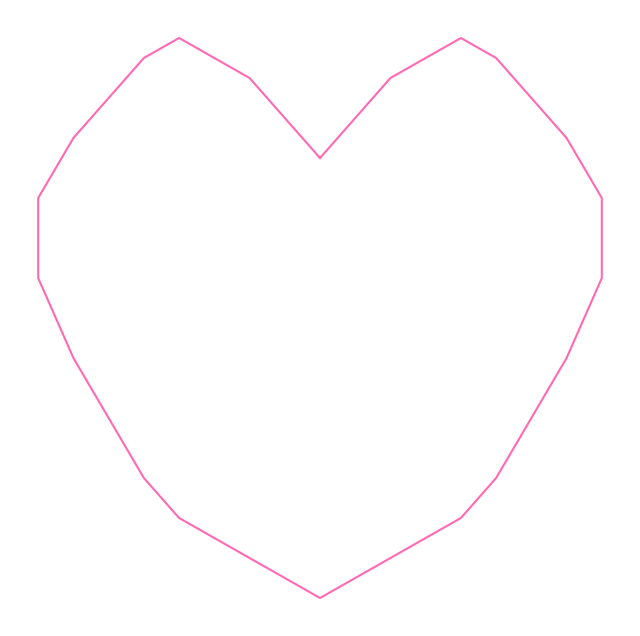

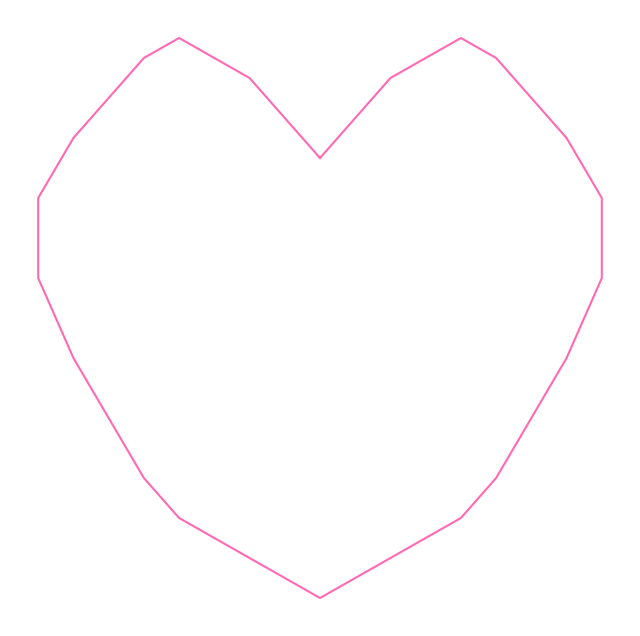

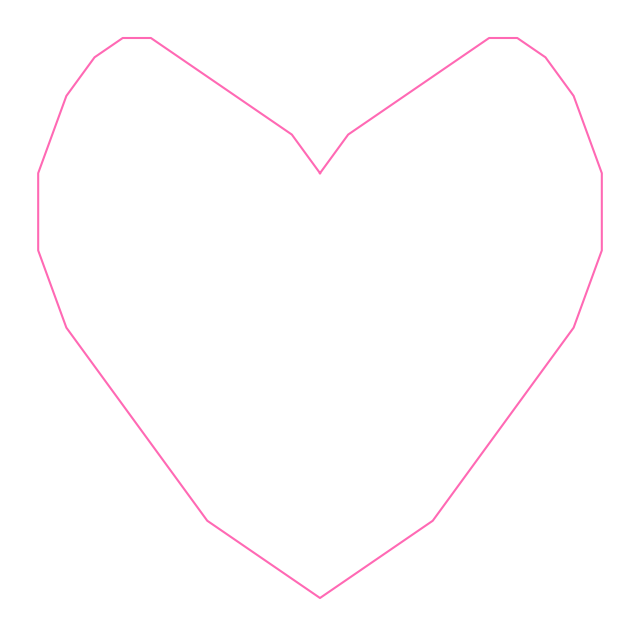

In [2]:
points = [(0, 3),
(-1, 4), (-2, 5), (-3, 5), (-4, 4), (-5, 2), (-5, 0), (-4, -3), (-2, -5), (0, -4),
(2, -5), (4, -3), (5, 0), (5, 2), (4, 4), (3, 5), (2, 5), (1, 4),
(0, 3)]

points2 = [(0, 4),
(-1, 5), (-2, 6), (-3, 6.5), (-4, 7), (-5, 6.5), (-6, 5.5), (-7, 4.5), (-8, 3), (-8, 1), (-7, -1), (-6, -2.5), (-5, -4), (-4, -5), (-3, -5.5), (-2, -6), (-1, -6.5), (0, -7),
(1, -6.5), (2, -6), (3, -5.5), (4, -5), (5, -4), (6, -2.5), (7, -1), (8, 1), (8, 3), (7, 4.5), (6, 5.5), (5, 6.5), (4, 7), (3, 6.5), (2, 6), (1, 5),
(0, 4)]


points3=[(0, 4),
(-1, 5), (-2, 5.5), (-3, 6), (-4, 6.5), (-5, 7), (-6, 7.5), (-7, 7.5), (-8, 7), (-9, 6), (-9.5, 5), (-10, 4), (-10, 3), (-10, 2), (-9.5, 1), (-9, 0), (-8, -1), (-7, -2), (-6, -3), (-5, -4), (-4, -5), (-3, -5.5), (-2, -6), (-1, -6.5), (0, -7),
(1, -6.5), (2, -6), (3, -5.5), (4, -5), (5, -4), (6, -3), (7, -2), (8, -1), (9, 0), (9.5, 1), (10, 2), (10, 3), (10, 4), (9.5, 5), (9, 6), (8, 7), (7, 7.5), (6, 7.5), (5, 7), (4, 6.5), (3, 6), (2, 5.5), (1, 5),
(0, 4)]

fig, ax = plt.subplots(figsize=[8,8])
plt.plot([x[0] for x in points2],[x[1] for x in points2],color='hotpink')
plt.axis('off')
plt.show()

fig, ax = plt.subplots(figsize=[8,8])
plt.plot([x[0] for x in points2],[x[1] for x in points2],color='hotpink')
plt.axis('off')
plt.show()


fig, ax = plt.subplots(figsize=[8,8])
plt.plot([x[0] for x in points3],[x[1] for x in points3],color='hotpink')
plt.axis('off')
plt.show()


Now we'll wrap those up in a geodataframe so that we can work with them the same way that a regular districting would work. 

In [3]:
heart = Polygon(points3)

In [4]:
heart_df = gpd.GeoDataFrame({"name":["Heart1","Heart2","Heart3"],"geometry":[ Polygon(points), Polygon(points2),heart]})

(-11.0, 11.0, -7.725, 8.225)

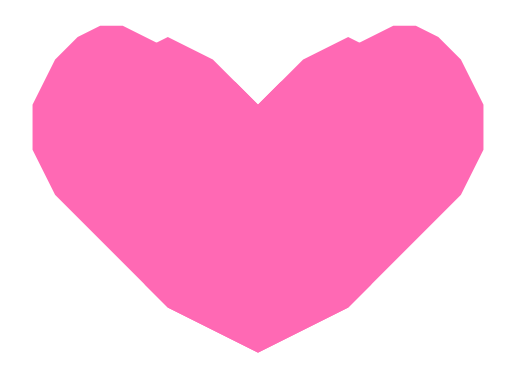

In [5]:
heart_df.plot(color='hotpink')
plt.axis('off')

In [6]:
heart_df.head()

name                                           geometry
0  Heart1  POLYGON ((0.00000 3.00000, -1.00000 4.00000, -...
1  Heart2  POLYGON ((0.00000 4.00000, -1.00000 5.00000, -...
2  Heart3  POLYGON ((0.00000 4.00000, -1.00000 5.00000, -...

The perimeters of polygons in geodataframes are accessed with the .length method while .area provides the areas. We'll use these to compute the Polsby-Popper score of our hearts directly in a function: 

In [7]:
def polsby_popper(gdf):
    return 4*math.pi * gdf.area/(gdf.length**2)

Since pandas vectorizes operations we can apply this to all the rows of the dataframe at once: 

In [8]:
heart_df.length

0    35.410963
1    49.083401
2    57.103942
dtype: float64

In [9]:
polsby_popper(heart_df)

0    0.781680
1    0.813702
2    0.751471
dtype: float64

Looking at all of the scores at once gives us some different axes to compare the plans along. 

In [10]:
print("Polsby-Popper")
print(polsby_popper(heart_df))
print("Convex Hull")
print(c_hull_ratio(heart_df))
print("Reock")
for ind, row in heart_df.iterrows():
    print((row['geometry'].area/(math.pi * make_circle(list(row['geometry'].convex_hull.exterior.coords))[2]**2)))
    
    

Polsby-Popper
0    0.781680
1    0.813702
2    0.751471
dtype: float64
Convex Hull
0    0.928571
1    0.939759
2    0.913349
dtype: float64
Reock
0.7866351246680611
0.7384940845430005
0.6145586911469226


Next I've included some code for visualizing the bounding shapes for the hearts. For these simple shapes everything is pretty well-behaved but it already highlights some of the complexity of evaluating sets of shapes together. 

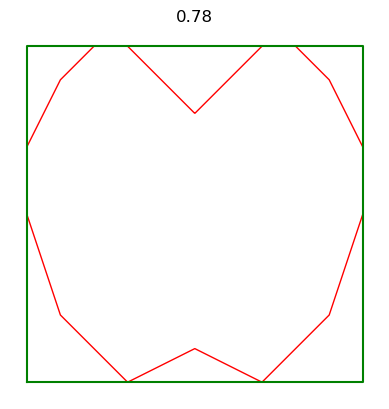

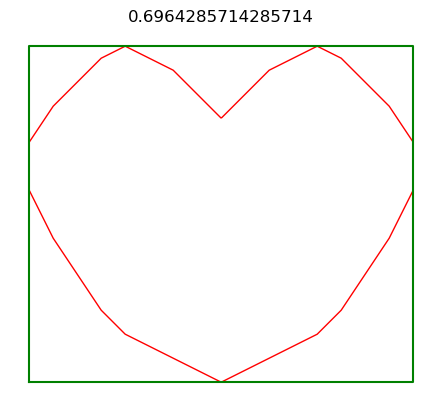

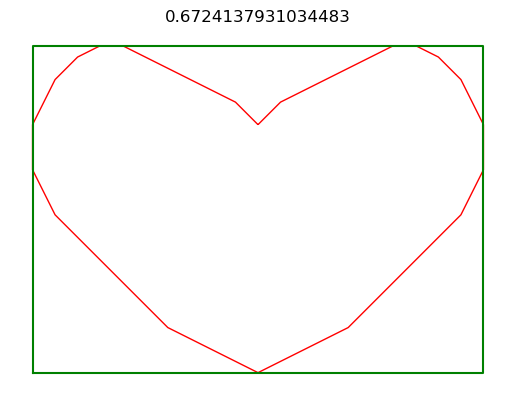

In [11]:
for ind, row in heart_df.iterrows():
    fig, ax = plt.subplots()

    outside = list(row['geometry'].convex_hull.envelope.exterior.coords)
    
    plt.plot([x[0] for x in outside],[x[1] for x in outside],color='green')
    
    heart_df.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    
    plt.title(row['geometry'].area/row['geometry'].convex_hull.envelope.area)
    plt.axis('off')
    plt.show()

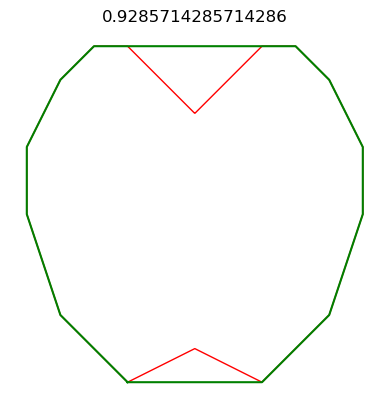

In [12]:
for ind, row in heart_df.iterrows():
    fig, ax = plt.subplots()

    outside = list(row['geometry'].convex_hull.exterior.coords)
    
    plt.plot([x[0] for x in outside],[x[1] for x in outside],color='green')
    
    heart_df.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    plt.title(row['geometry'].area/row['geometry'].convex_hull.area)
    plt.axis('off')
    plt.show()

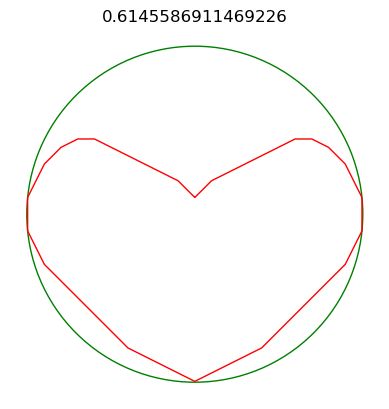

In [13]:
for ind, row in heart_df.iterrows():
    fig, ax = plt.subplots()

    circle_parts2 = make_circle(list(row['geometry'].convex_hull.exterior.coords))
    circle2 = plt.Circle((circle_parts2[0], circle_parts2[1]),circle_parts2[2], color='g', fill=False)
    ax.add_patch(circle2)
    heart_df.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    

    plt.title((row['geometry'].area/(math.pi * make_circle(list(row['geometry'].convex_hull.exterior.coords))[2]**2)))
    plt.axis('off')
    plt.show()

35.41096285406687


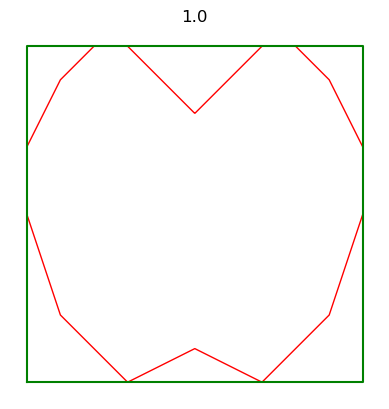

49.083401247621005


57.10394155822034


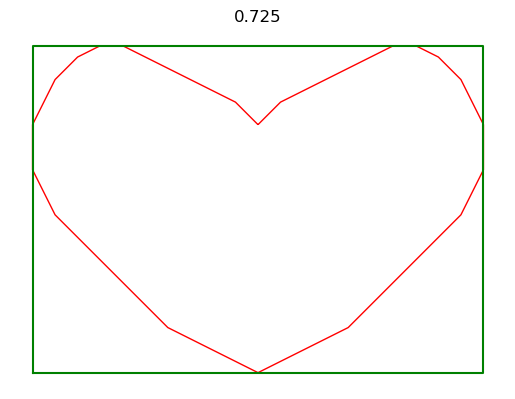

In [14]:
for ind, row in heart_df.iterrows():
    fig, ax = plt.subplots()


    print(row['geometry'].length)
    outside = list(row['geometry'].convex_hull.envelope.exterior.coords)

    o_len = max([x[0] for x in outside]) - min([x[0] for x in outside])
    
    o_wid = max([x[1] for x in outside]) - min([x[1] for x in outside])
    
    lw = min(o_len/o_wid,o_wid/o_len)
    
    plt.plot([x[0] for x in outside],[x[1] for x in outside],color='green')
    
    heart_df.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    

    plt.title(lw)
    plt.axis('off')
    plt.show()

The next visualizations do something similar with the outlines but also visualize a "dissolved" version where the shape fills up the bounding area from the bottom up. This uses code generated by CISER's own David Rice - a WSU graduate student in Statistics. 

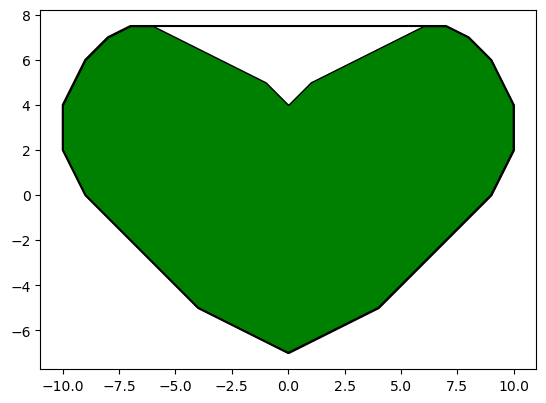

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


        minx  miny  maxx  maxy
name                          
Heart3 -10.0  -7.0  10.0   7.5


C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


name
Heart3    0.913349
dtype: float64

In [15]:
district_hull_vis(district_num = "Heart3", district_color = "green",  district_col_name = "name", df = heart_df.set_crs(4326))

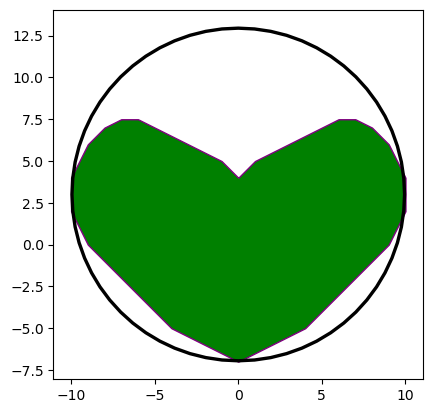

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])


0.615547017725487

In [16]:
#Example
district_reock_vis(district_num = "Heart3", district_color = "green", district_edge_color = "purple", district_col_name = "name",
                   circle_color = "black", pie_color = "green",
                   pie_edge_color = "black", df = heart_df)

# Washington 

The next set of examples walk through a similar set of computations for several different districtings of Washington for 2020. As you are looking through them consider the problem faced by analysts: "Which of these is the best map?" and whether that question even makes sense.

**Note:** The WA data is zipped for github so you'll need to unzip it before running the following. 

In [17]:
CON = gpd.read_file("./WA/wa_cong_adopted_2022/CONG_AMEND_FINAL.shp")
Precincts = gpd.read_file("./WA/WA_2020/WA_2020_w_plans_votes/WA_2020_w_plans_votes_t.shp")

In [18]:
CON.head()

DISTRICT  DISTRICTN    Shape_Leng    Shape_Area  ID  \
0        1        1.0  9.229290e+05  9.743488e+09   1   
1       10       10.0  1.052520e+06  2.205028e+10  10   
2        2        2.0  2.527922e+06  1.628946e+11   2   
3        3        3.0  2.565152e+06  2.159487e+11   3   
4        4        4.0  5.268709e+06  5.072447e+11   4   

                                            geometry  
0  POLYGON ((1248301.037 1052228.322, 1248355.566...  
1  POLYGON ((1210980.559 706430.568, 1210980.663 ...  
2  POLYGON ((1555959.331 1337876.149, 1555828.792...  
3  POLYGON ((1107694.858 592411.578, 1110320.538 ...  
4  POLYGON ((1627182.093 1337790.433, 1627608.789...

In [19]:
Precincts.head()

STATEFP20 COUNTYFP20 VTDST20      GEOID20 VTDI20          NAME20  \
0        53        041  000114  53041000114      A    CENTRALIA 14   
1        53        061  001777  53061001777      A     LYNNWOOD 27   
2        53        009  000222  53009000222      A  DUNGENESS EAST   
3        53        009  000216  53009000216      A           CLARK   
4        53        009  000210  53009000210      A          BLUFFS   

                       NAMELSAD20 LSAD20 MTFCC20 FUNCSTAT20  ...  G20ATGLARK  \
0    CENTRALIA 14 Voting District     V2   G5240          N  ...           0   
1     LYNNWOOD 27 Voting District     V2   G5240          N  ...           2   
2  DUNGENESS EAST Voting District     V2   G5240          N  ...         403   
3           CLARK Voting District     V2   G5240          N  ...         213   
4          BLUFFS Voting District     V2   G5240          N  ...         300   

   Fain Walkinshaw Graves Sims CD SLDU         C_X        C_Y  \
0     5          2      2    2  1    3 -122.960425  46.693856   
1     0          0      1    0  6   12 -122.290240  47.809949   
2     5          5      5    5  8   45 -123.127165  48.126344   
3     5          5      5    5  8   45 -123.370408  48.101276   
4     5          5      5    5  8   45 -123.301978  48.184904   

                                            geometry  
0  POLYGON ((-122.96391 46.69201, -122.96216 46.6...  
1  POLYGON ((-122.29233 47.81134, -122.29232 47.8...  
2  POLYGON ((-123.14954 48.11613, -123.14921 48.1...  
3  POLYGON ((-123.38117 48.09574, -123.38111 48.0...  
4  POLYGON ((-123.31824 48.11822, -123.31814 48.2...  

[5 rows x 86 columns]

In [20]:
graph = Graph.from_json("./WA/WA_2020/WA_2020_w_plans_votes/WA_2020_w_plans_votes_t.json")

(480980.60819124134, 2649555.861648868, 18148.4055390507, 1419285.2529644817)

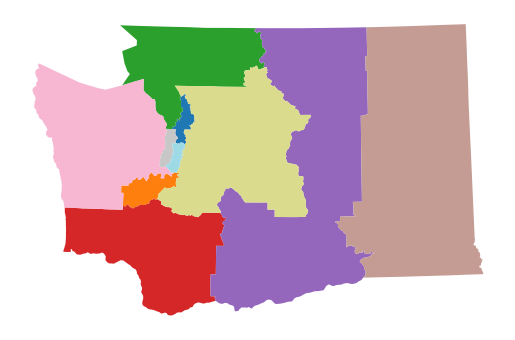

In [21]:
CON.plot(column="DISTRICT",cmap="tab20")
plt.axis('off')

In [22]:
CON.area

0    9.743488e+09
1    2.205028e+10
2    1.628946e+11
3    2.159487e+11
4    5.072447e+11
5    5.293858e+11
6    2.492885e+11
7    7.054832e+09
8    2.787188e+11
9    5.955352e+09
dtype: float64

In [23]:
CON.crs

<Projected CRS: PROJCS["NAD83(HARN) / Washington South (ftUS)",GEO ...>
Name: NAD83(HARN) / Washington South (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [24]:
CON.to_crs("EPSG:3857").area

0    2.010064e+09
1    4.410709e+09
2    3.452883e+10
3    4.206862e+10
4    1.022656e+11
5    1.075038e+11
6    5.099625e+10
7    1.437944e+09
8    5.680121e+10
9    1.208652e+09
dtype: float64

In [25]:
CON.to_crs("EPSG:4326").area

C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\3927585853.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  CON.to_crs("EPSG:4326").area


0    0.108797
1    0.242524
2    1.842873
3    2.344126
4    5.598809
5    5.864495
6    2.772035
7    0.078313
8    3.093528
9    0.065969
dtype: float64

In [26]:
polsby_popper(CON)

0    0.143743
1    0.250128
2    0.320324
3    0.412415
4    0.229625
5    0.501392
6    0.494847
7    0.361753
8    0.264394
9    0.234787
dtype: float64

In [27]:
polsby_popper(CON.to_crs("EPSG:4326"))

C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)
C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)


0    0.142892
1    0.240116
2    0.271187
3    0.376290
4    0.218855
5    0.524298
6    0.475112
7    0.384995
8    0.241770
9    0.228726
dtype: float64

In [28]:
CON['PP1'] = polsby_popper(CON)
CON['PP2'] = polsby_popper(CON.to_crs("EPSG:4326"))
CON['PP3'] = polsby_popper(CON.to_crs("EPSG:3857"))

fig, ax = plt.subplots(1,3,figsize=[12,8])

CON.plot(column='PP1',cmap='jet',ax=ax[0])
ax[0].axis('off')
CON.plot(column='PP2',cmap='jet',ax=ax[1])
ax[1].axis('off')
CON.plot(column='PP3',cmap='jet',ax=ax[2])
ax[2].axis('off')


C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)
C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)


(480980.60819124134, 2649555.861648868, 18148.4055390507, 1419285.2529644817)

C:\Users\daryl\anaconda3\Lib\site-packages\maup\intersections.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
C:\Users\daryl\anaconda3\Lib\site-packages\maup\intersections.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
C:\Users\daryl\anaconda3\Lib\site-packages\maup\assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


(-125.24561915, -116.51942585, 45.3705961, 49.17538389999999)

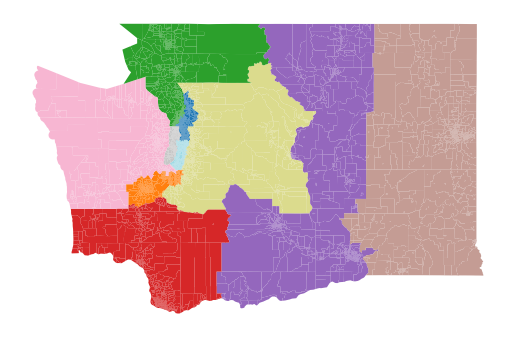

In [29]:
assign_CON = maup.assign(Precincts,CON.to_crs('EPSG:4269'))
Precincts["CON"] = assign_CON
Precincts.plot(column="CON",cmap='tab20')
plt.axis('off')

In [30]:
CON_from_Precincts = Precincts.dissolve(by='CON')
Graves_from_Precincts = Precincts.dissolve(by='Graves')
Sims_from_Precincts = Precincts.dissolve(by='Sims')
Walkinshaw_from_Precincts = Precincts.dissolve(by='Walkinshaw')
Fain_from_Precincts = Precincts.dissolve(by='Fain')


In [31]:
CON['PP4'] = polsby_popper(CON_from_Precincts)


C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)
C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)


(480980.60819124134, 2649555.861648868, 18148.4055390507, 1419285.2529644817)

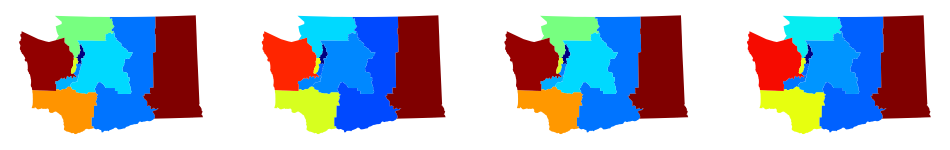

In [32]:
fig, ax = plt.subplots(1,4,figsize=[12,8])

CON.plot(column='PP1',cmap='jet',ax=ax[0])
ax[0].axis('off')
CON.plot(column='PP2',cmap='jet',ax=ax[1])
ax[1].axis('off')
CON.plot(column='PP3',cmap='jet',ax=ax[2])
ax[2].axis('off')
CON.plot(column='PP4',cmap='jet',ax=ax[3])
ax[3].axis('off')


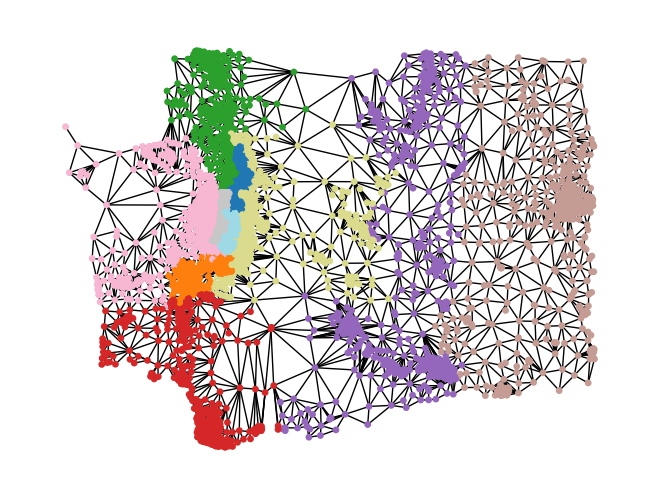

In [33]:
graph.add_data(Precincts,columns=["CON"])
nx.draw(graph,pos=[(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()],node_size=15,node_color= [graph.nodes[n]["CON"] for n in graph.nodes()],cmap='tab20')


In [34]:
polsby_popper(CON)
c_hull_ratio(CON)
for ind, row in CON.iterrows():
    print((row['geometry'].area/(math.pi * make_circle(list(row['geometry'].convex_hull.exterior.coords))[2]**2)))


0.24483061484487853
0.3423483466811545
0.462738405891194
0.45536543501960874
0.3447493251864143
0.47031017139540787
0.5394466777797654
0.28659305027948045
0.5406336919681637
0.38450346636800886


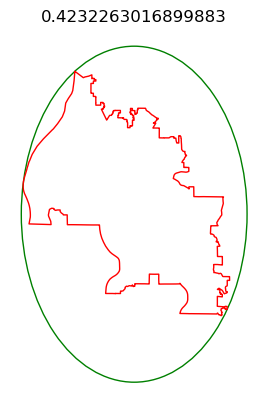

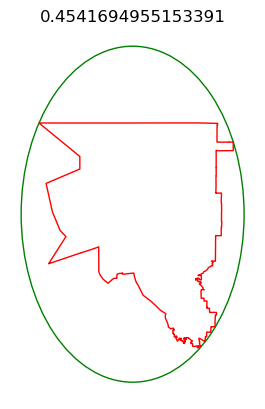

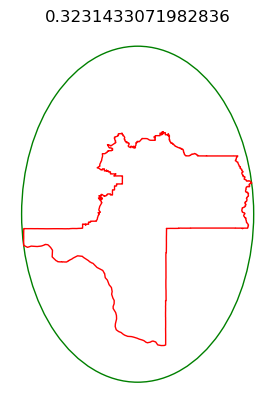

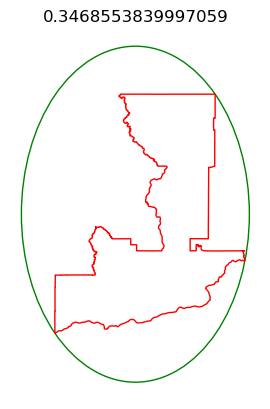

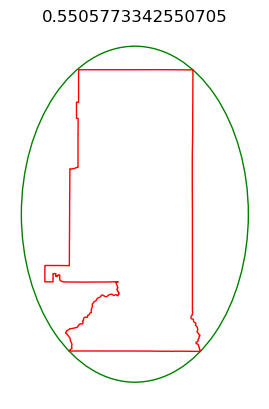

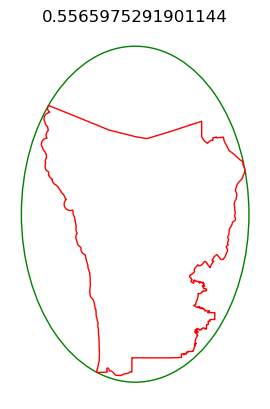

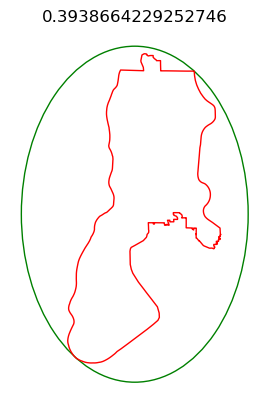

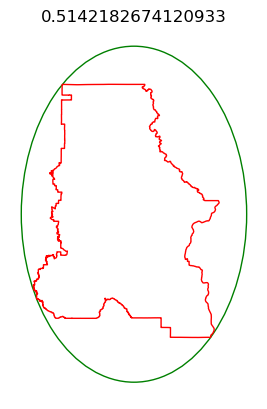

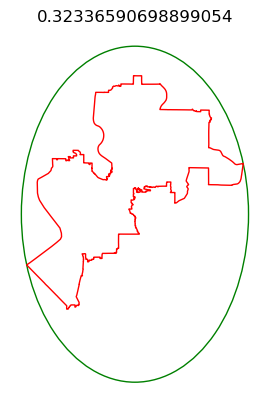

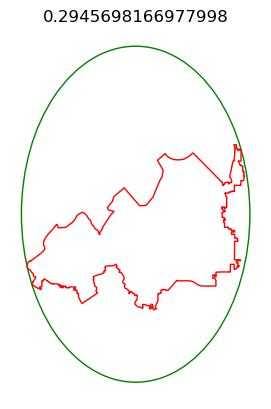

In [35]:
for ind, row in Fain_from_Precincts.iterrows():
    fig, ax = plt.subplots()

    circle_parts2 = make_circle(list(row['geometry'].convex_hull.exterior.coords))
    circle2 = plt.Circle((circle_parts2[0], circle_parts2[1]),circle_parts2[2], color='g', fill=False)
    ax.add_patch(circle2)
    Fain_from_Precincts.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    

    #plt.xlim(circle_parts2[0]-circle_parts2[2],circle_parts2[0]+circle_parts2[2])
    #plt.ylim(-11,11)
    plt.title((row['geometry'].area/(math.pi * make_circle(list(row['geometry'].convex_hull.exterior.coords))[2]**2)))
    plt.axis('off')
    plt.show()

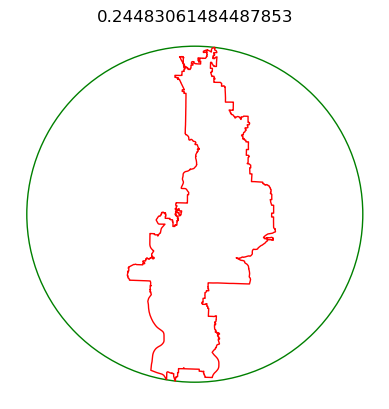

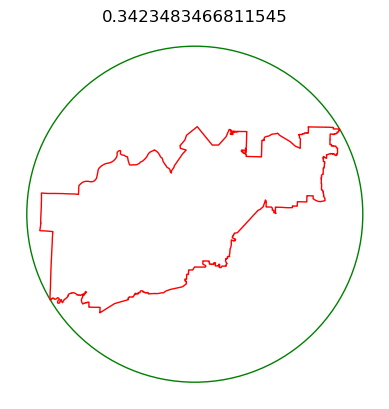

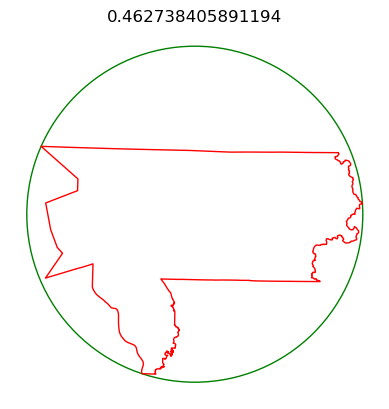

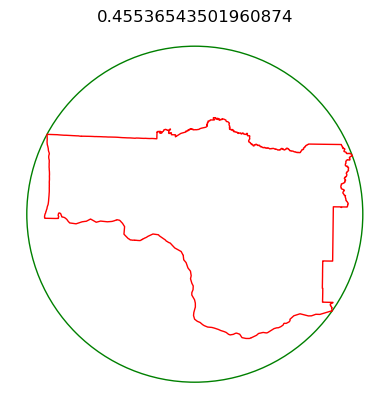

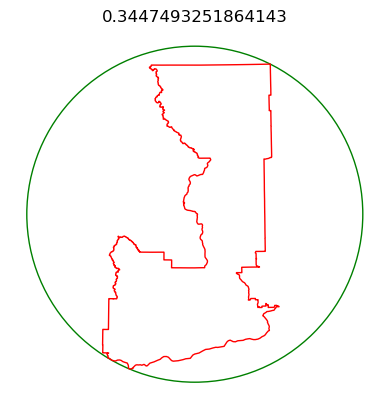

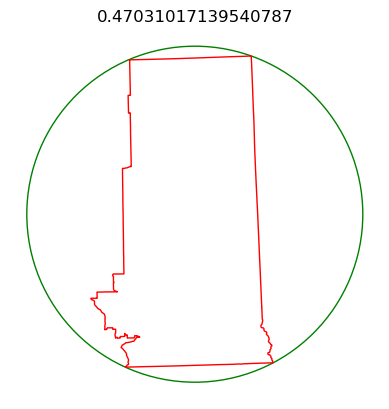

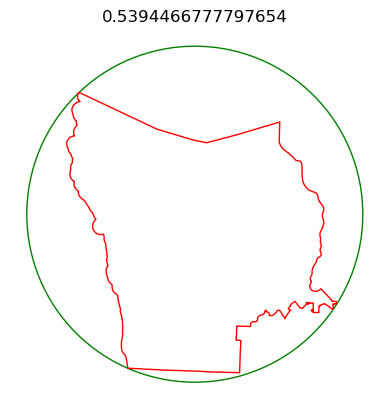

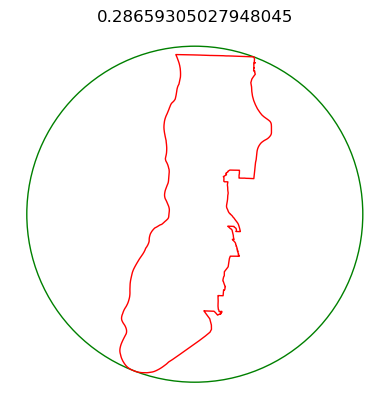

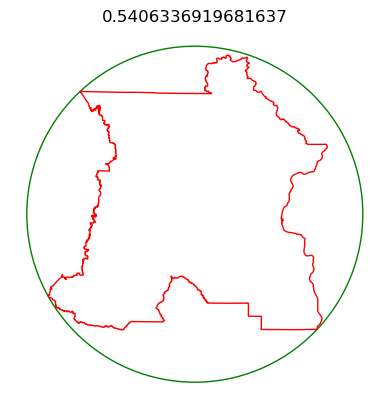

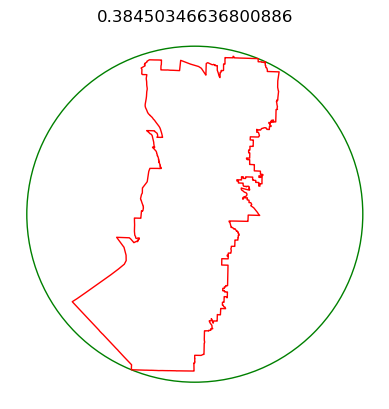

In [36]:
for ind, row in CON.iterrows():
    fig, ax = plt.subplots()

    circle_parts2 = make_circle(list(row['geometry'].convex_hull.exterior.coords))
    circle2 = plt.Circle((circle_parts2[0], circle_parts2[1]),circle_parts2[2], color='g', fill=False)
    ax.add_patch(circle2)
    CON.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    

    #plt.xlim(circle_parts2[0]-circle_parts2[2],circle_parts2[0]+circle_parts2[2])
    #plt.ylim(-11,11)
    plt.title((row['geometry'].area/(math.pi * make_circle(list(row['geometry'].convex_hull.exterior.coords))[2]**2)))
    plt.axis('off')
    plt.show()

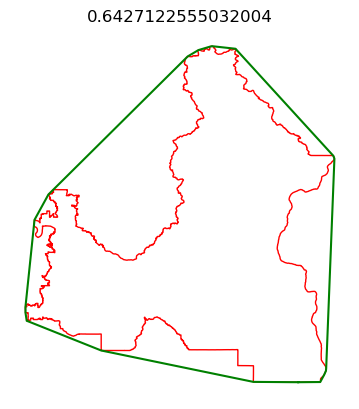

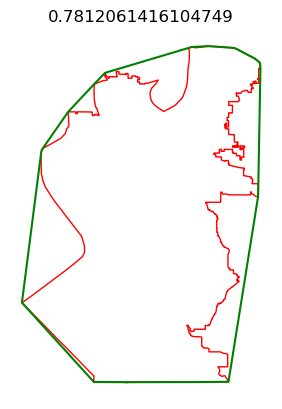

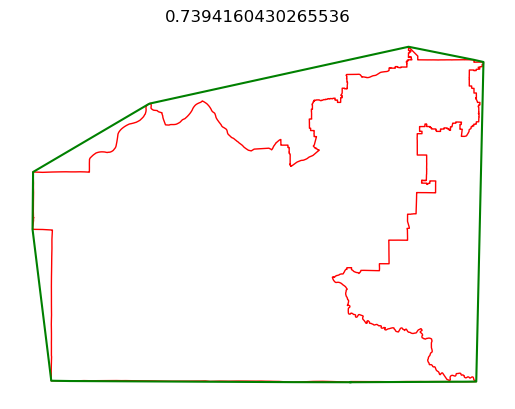

In [37]:
for ind, row in Walkinshaw_from_Precincts.iterrows():
    fig, ax = plt.subplots()

    #circle_parts2 = make_circle(list(row['geometry'].convex_hull.exterior.coords))
    #circle2 = plt.Circle((circle_parts2[0], circle_parts2[1]),circle_parts2[2], color='g', fill=False)
    #ax.add_patch(circle2)
    
    outside = list(row['geometry'].convex_hull.exterior.coords)
    
    plt.plot([x[0] for x in outside],[x[1] for x in outside],color='green')
    
    Walkinshaw_from_Precincts.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    

    #plt.xlim(circle_parts2[0]-circle_parts2[2],circle_parts2[0]+circle_parts2[2])
    #plt.ylim(-11,11)
    plt.title(row['geometry'].area/row['geometry'].convex_hull.area)
    plt.axis('off')
    plt.show()

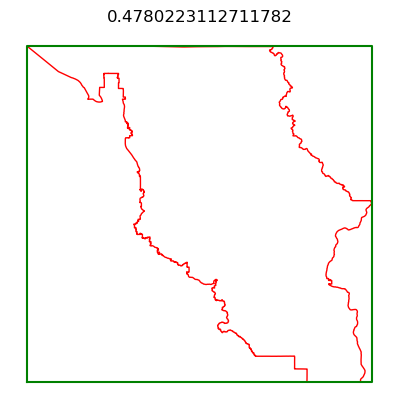

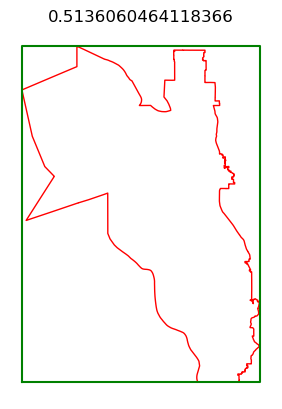

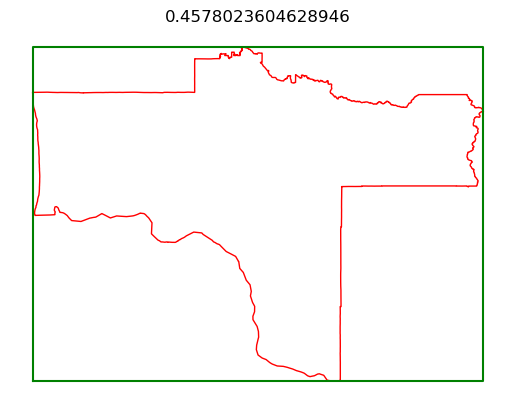

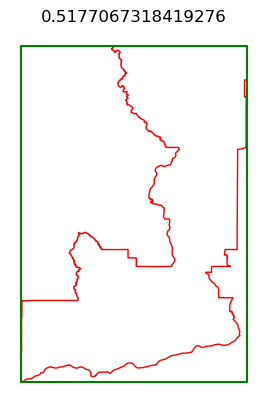

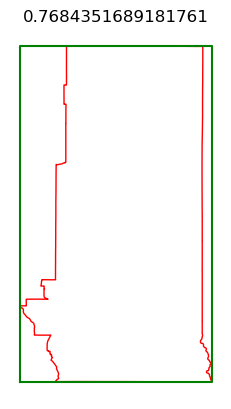

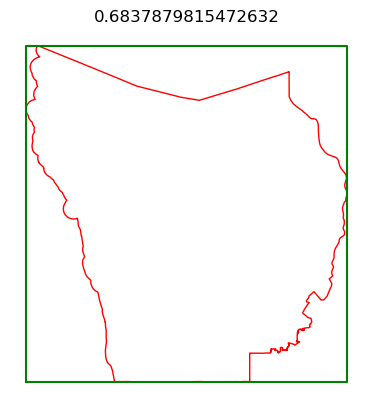

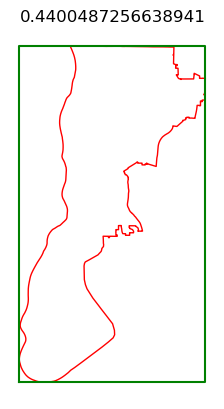

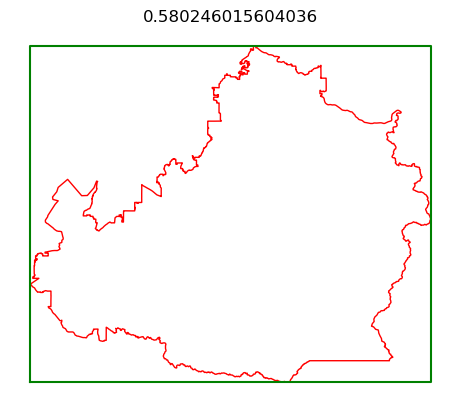

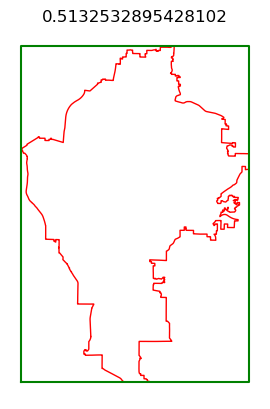

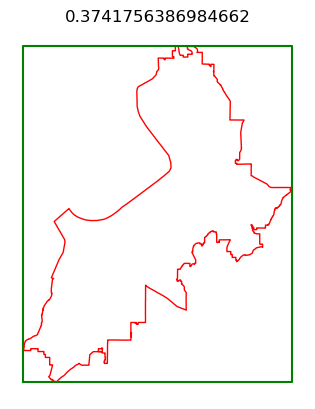

In [38]:
for ind, row in Graves_from_Precincts.iterrows():
    fig, ax = plt.subplots()

    #circle_parts2 = make_circle(list(row['geometry'].convex_hull.exterior.coords))
    #circle2 = plt.Circle((circle_parts2[0], circle_parts2[1]),circle_parts2[2], color='g', fill=False)
    #ax.add_patch(circle2)
    
    outside = list(row['geometry'].convex_hull.envelope.exterior.coords)
    
    plt.plot([x[0] for x in outside],[x[1] for x in outside],color='green')
    
    Graves_from_Precincts.loc[[ind],'geometry'].plot(facecolor="None",edgecolor='red',ax=ax)
    

    #plt.xlim(circle_parts2[0]-circle_parts2[2],circle_parts2[0]+circle_parts2[2])
    #plt.ylim(-11,11)
    plt.title(row['geometry'].area/row['geometry'].convex_hull.envelope.area)
    plt.axis('off')
    plt.show()

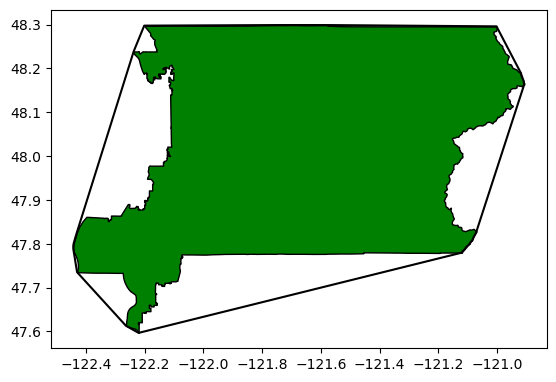

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx      maxy
CD                                             
6  -122.442924  47.596821 -120.907399  48.29899


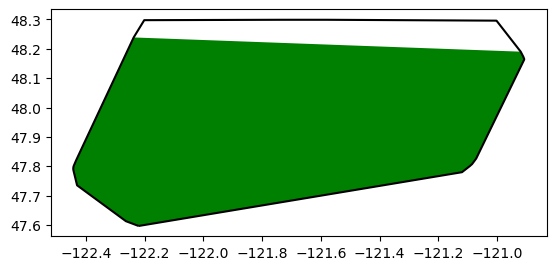

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


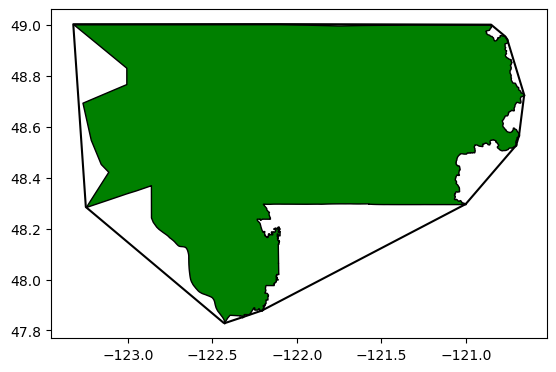

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


         minx       miny        maxx       maxy
CD                                             
0  -123.32224  47.828098 -120.655857  49.002439


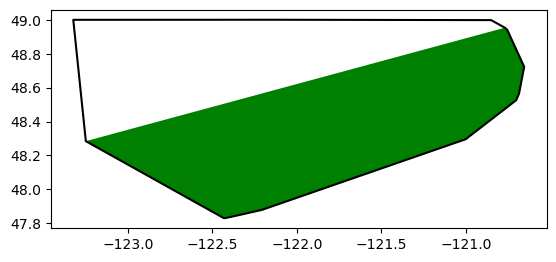

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


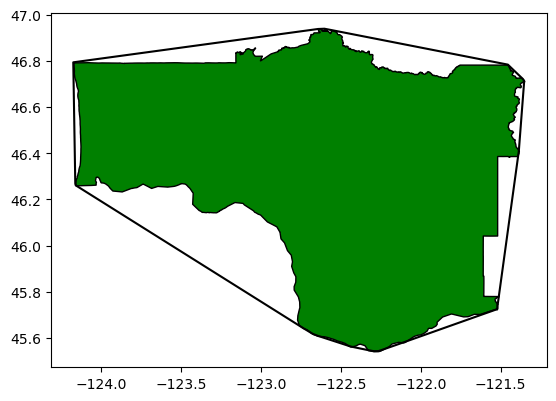

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx       maxy
CD                                              
1  -124.175131  45.543541 -121.353179  46.939182


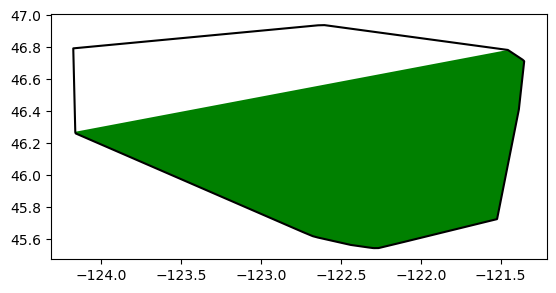

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


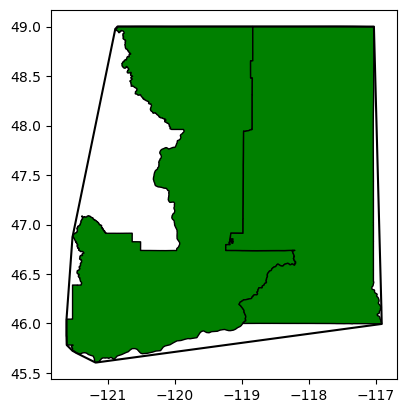

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx       maxy
CD                                              
4  -121.612731  45.606098 -116.916071  49.000737


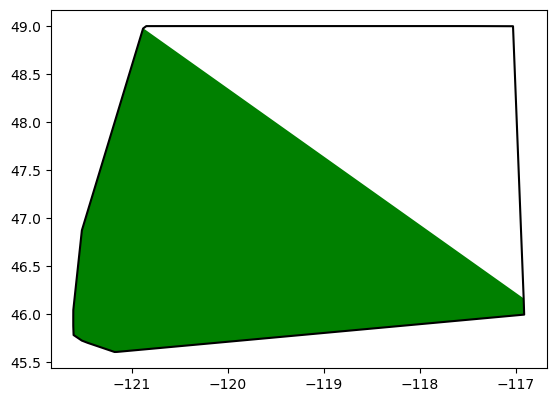

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


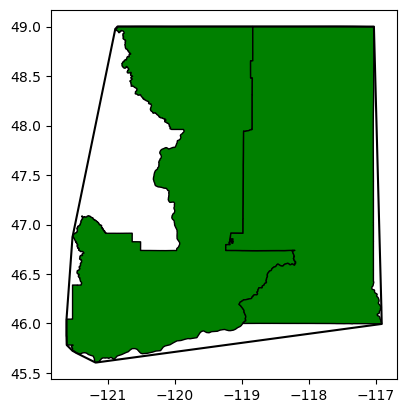

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx       maxy
CD                                              
4  -121.612731  45.606098 -116.916071  49.000737


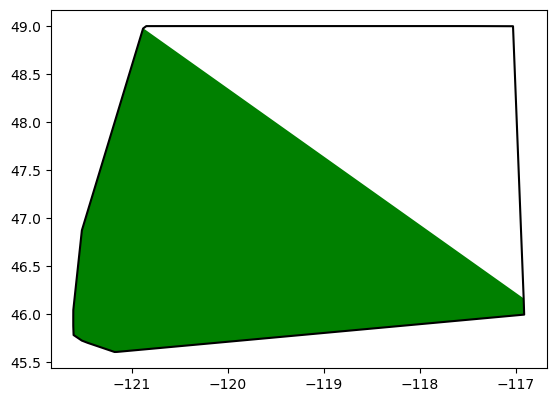

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


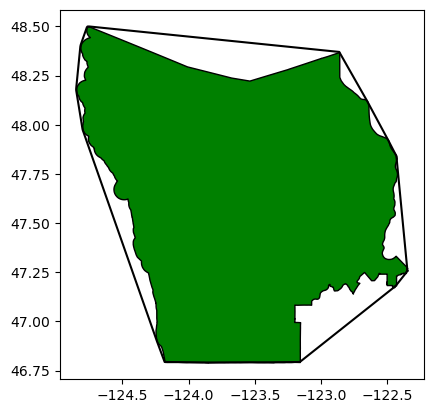

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx       maxy
CD                                              
8  -124.848974  46.790916 -122.348378  48.499784


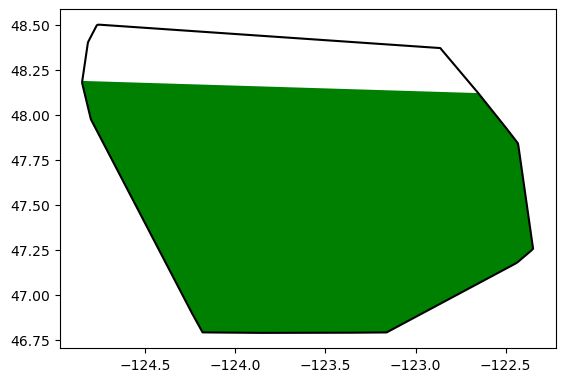

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


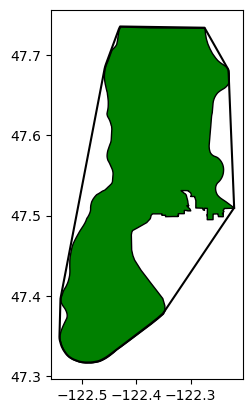

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx      maxy
CD                                             
7  -122.541661  47.317294 -122.219822  47.73528


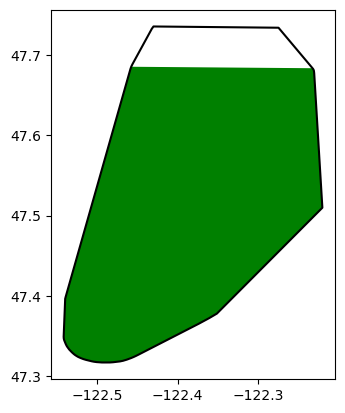

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx       maxy
CD                                              
9  -122.437252  46.728406 -119.859708  48.550836


C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx       maxy
CD                                              
9  -122.437252  46.728406 -119.859708  48.550836


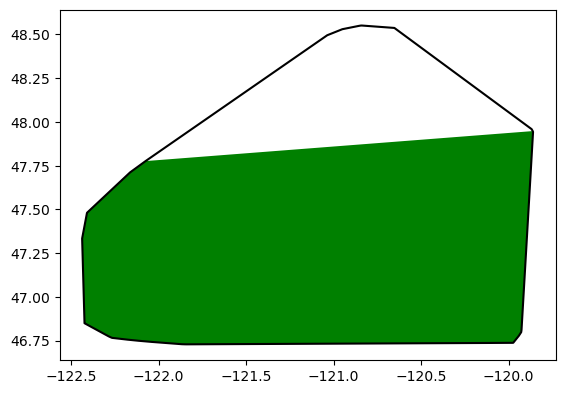

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


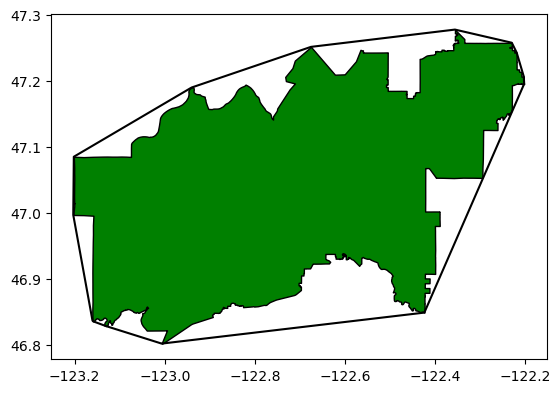

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:569: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (my_district["geometry"].area)


          minx       miny        maxx       maxy
CD                                              
2  -123.203101  46.802398 -122.202034  47.277466


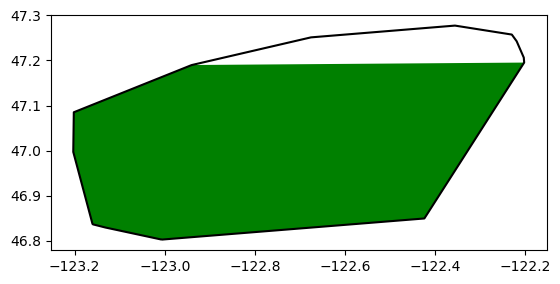

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:614: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hull_area = my_district["geometry"].convex_hull.area.iloc[0]


In [39]:
for plan_num in list(Sims_from_Precincts['CD']):
    district_hull_vis(district_num = plan_num, district_color = "green",  district_col_name = "CD", df = Sims_from_Precincts)

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


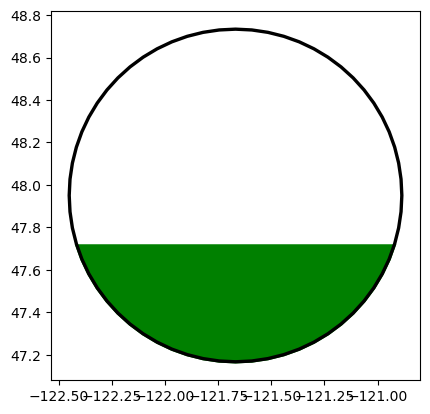

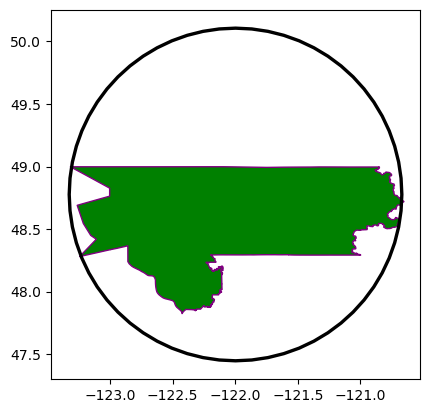

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


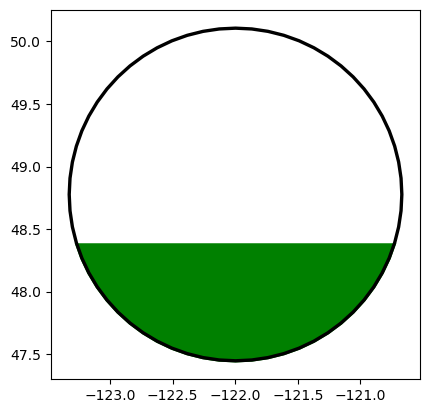

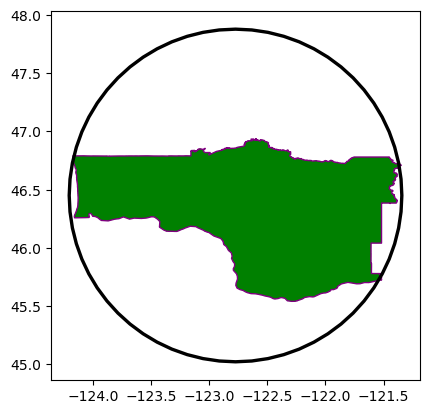

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


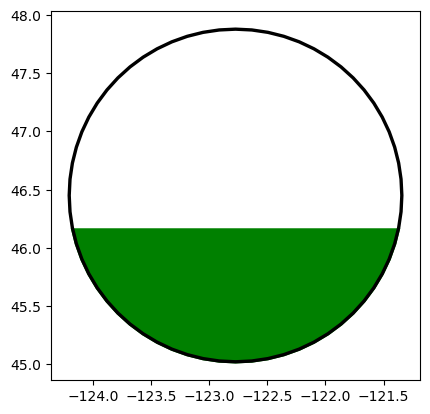

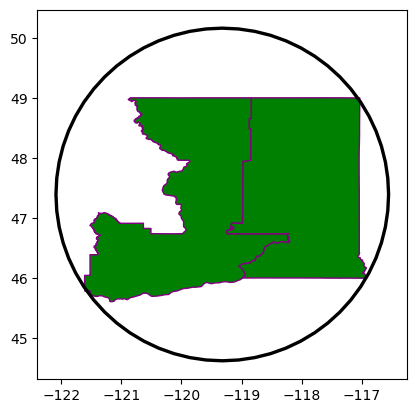

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


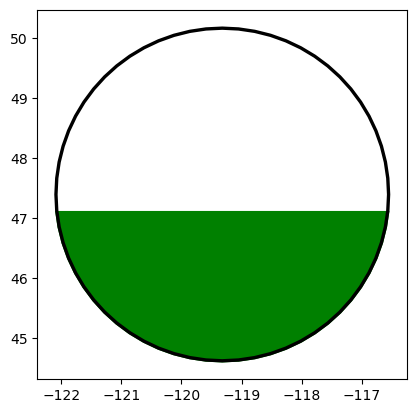

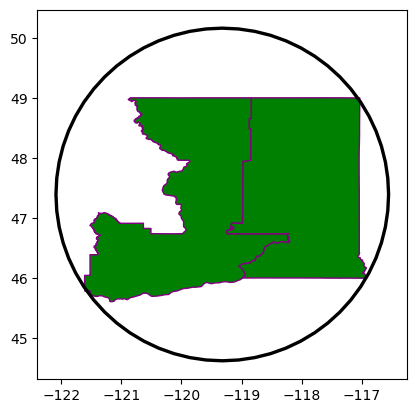

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


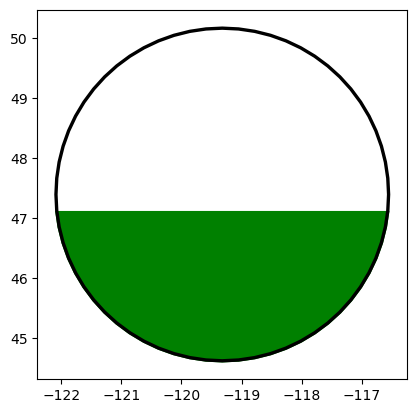

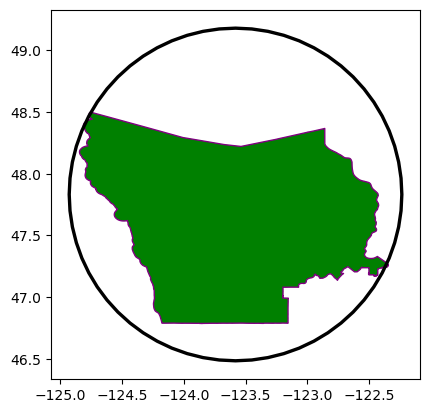

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


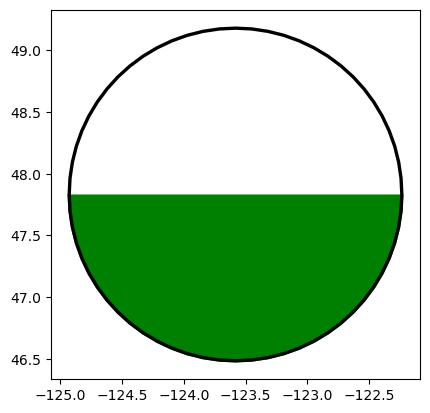

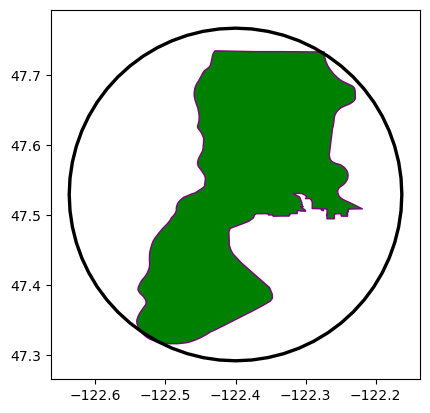

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


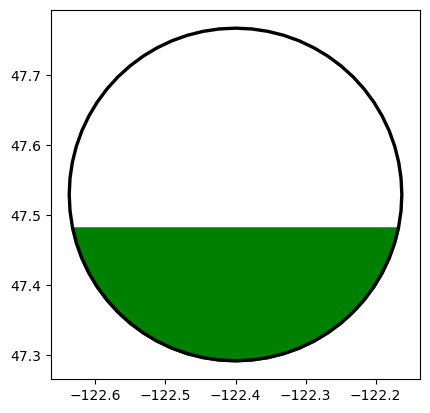

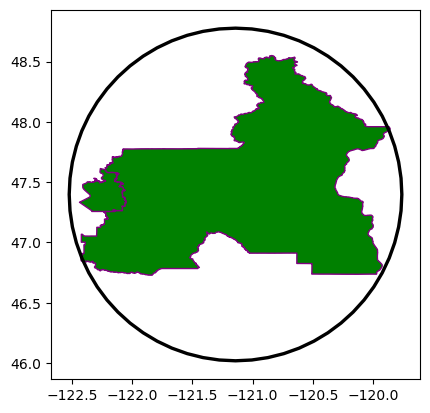

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


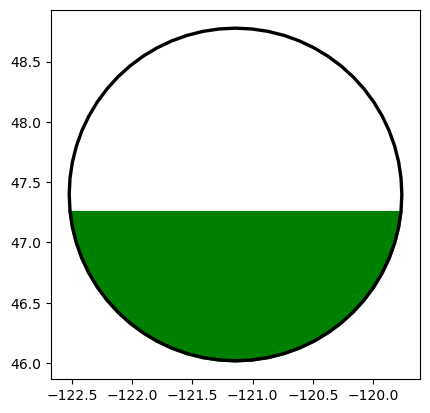

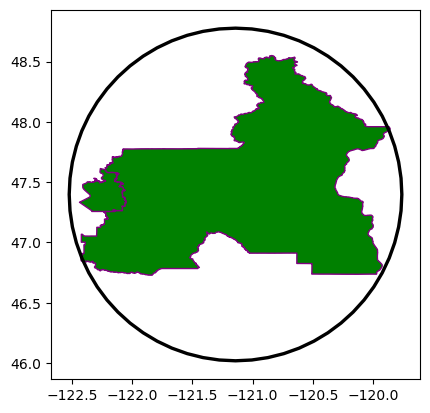

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


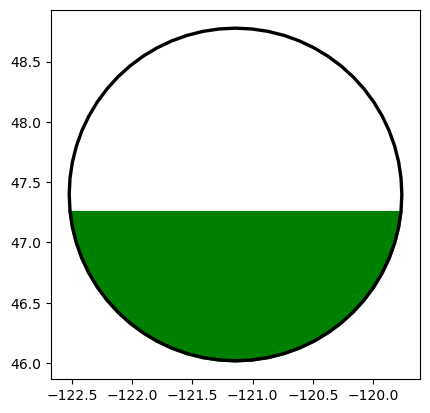

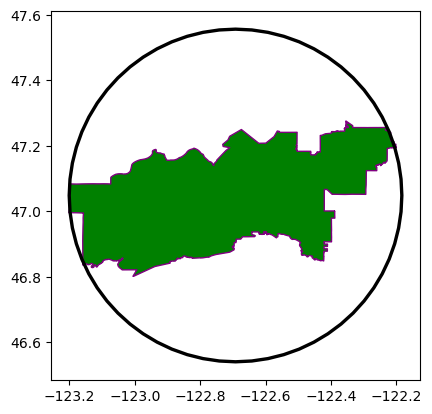

C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:482: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle_area = (circle_area_df['geometry'].area.iloc[0])
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:483: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_area = (df_indexed.dissolve(by = district_col_name).area.iloc[0])


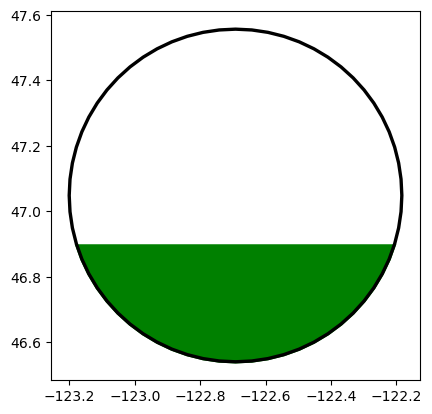

In [40]:
for plan_num in list(Sims_from_Precincts['CD']):
    district_reock_vis(district_num = plan_num, district_color = "green", district_edge_color = "purple", district_col_name = "CD",
                   circle_color = "black", pie_color = "green",
                   pie_edge_color = "black", df = Sims_from_Precincts)

In [41]:
plans = [CON_from_Precincts,Fain_from_Precincts,Graves_from_Precincts,Sims_from_Precincts,Walkinshaw_from_Precincts]

for plan in plans: 
    plan['PP'] = polsby_popper(plan)
    plan['CH'] = c_hull_ratio(plan)
    plan['R'] = 0
    plan['LW'] = 0
    plan['P'] = plan.length
    for ind, row in plan.iterrows():
        plan.loc[ind,'R']=(row['geometry'].area/(math.pi * make_circle(list(row['geometry'].convex_hull.exterior.coords))[2]**2))
        
        
        outside = list(row['geometry'].convex_hull.envelope.exterior.coords)

        o_len = max([x[0] for x in outside]) - min([x[0] for x in outside])

        o_wid = max([x[1] for x in outside]) - min([x[1] for x in outside])

        lw = min(o_len/o_wid,o_wid/o_len)
        
        plan.loc[ind,'LW'] = lw

    




C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)
C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\1788248590.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return 4*math.pi * gdf.area/(gdf.length**2)
C:\Users\daryl\Dropbox\CISER_GerryChain\compactness_metric_functions.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return geo.area
C:\Users\daryl\AppData\Local\Temp\ipykernel_1412\2782031518.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' ar

Here are the district by district scores for the Congressional plan and then all the scores for all of the plans:

In [42]:
CON_from_Precincts[['PP','CH','R','LW','P']]

PP        CH         R        LW          P
CON                                                   
0    0.132958  0.645219  0.352722  0.661016   3.181057
1    0.224730  0.794514  0.274761  0.447904   3.678996
2    0.269557  0.766912  0.325100  0.459365   9.268565
3    0.373899  0.799703  0.357828  0.494566   8.875438
4    0.216826  0.687285  0.395594  0.838500  18.023517
5    0.515044  0.889645  0.580948  0.845638  11.955422
6    0.475392  0.835101  0.457889  0.668792   8.560017
7    0.371759  0.824884  0.370714  0.677255   1.626839
8    0.236387  0.741854  0.473218  0.671868  12.829331
9    0.219862  0.752695  0.446350  0.945935   1.943322

In [43]:
plan_names = ['Current','Fain','Graves','Sims','Walkinshaw']
for metric in ['PP','CH','R','LW','P']:
    print(metric)
    for i in range(5): 
        plan = plans[i]
        print(plan_names[i],round(max(plan[metric]),3),round(np.mean(plan[metric]),3),round(min(plan[metric]),3))

PP
Current 0.515 0.304 0.133
Fain 0.424 0.275 0.179
Graves 0.57 0.313 0.207
Sims 0.496 0.318 0.215
Walkinshaw 0.501 0.301 0.159
CH
Current 0.89 0.774 0.645
Fain 0.855 0.737 0.621
Graves 0.892 0.761 0.657
Sims 0.882 0.777 0.658
Walkinshaw 0.849 0.761 0.643
R
Current 0.581 0.404 0.275
Fain 0.557 0.418 0.295
Graves 0.589 0.414 0.292
Sims 0.617 0.419 0.314
Walkinshaw 0.521 0.399 0.327
LW
Current 0.946 0.671 0.448
Fain 0.914 0.767 0.517
Graves 0.996 0.788 0.513
Sims 0.994 0.672 0.44
Walkinshaw 0.953 0.668 0.44
P
Current 18.024 7.994 1.627
Fain 20.352 8.135 1.659
Graves 18.958 7.88 1.775
Sims 18.624 8.206 1.58
Walkinshaw 20.842 8.426 1.588


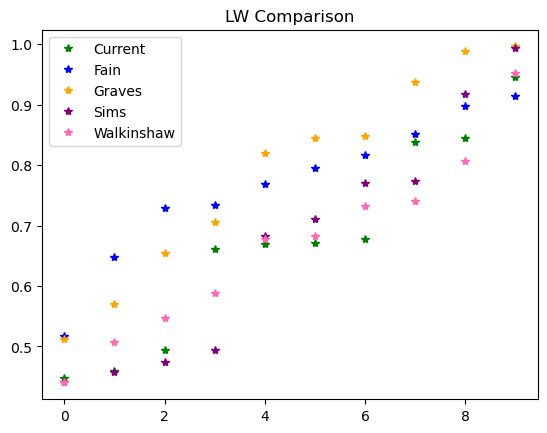

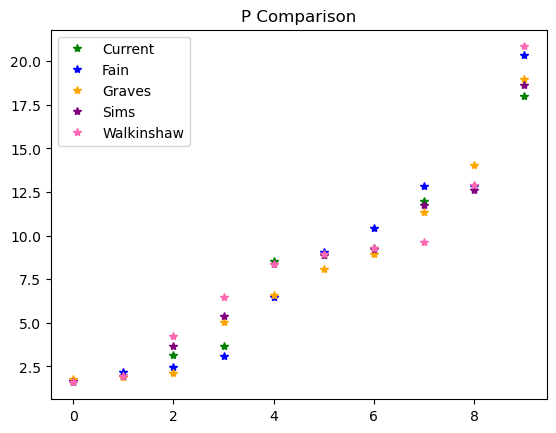

In [44]:
fig, ax = plt.subplots()
plan_colors = ['green','blue','orange','purple','hotpink']
for metric in ['PP','CH','R','LW','P']:

    for i in range(5):
        plan = plans[i]
        plt.plot(sorted(plan[metric]),'*',color=plan_colors[i],label=plan_names[i])
    plt.legend()
    plt.title(f'{metric} Comparison')
    plt.show()

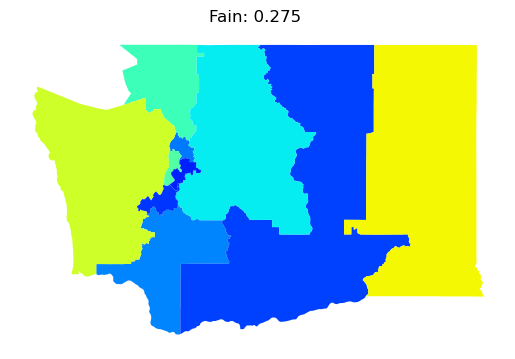

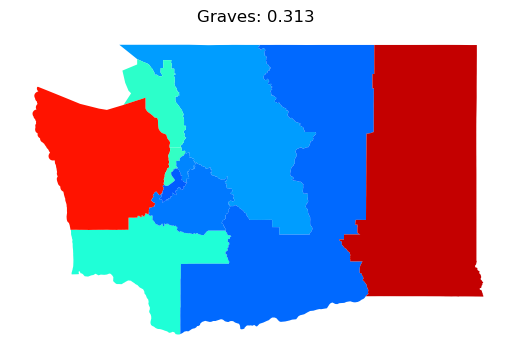

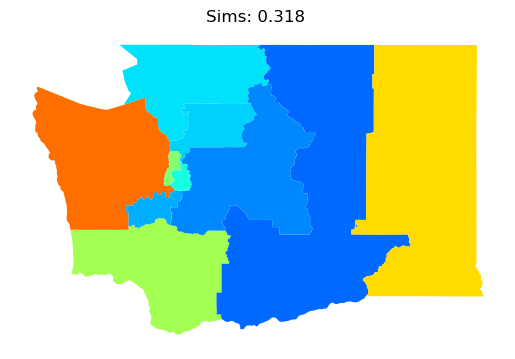

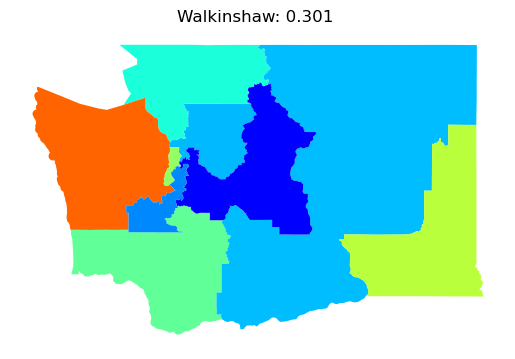

In [45]:
for i in range(5):
    plan = plans[i]
    plan.plot(column='PP',cmap='jet',vmin=.1,vmax=.6)
    plt.axis('off')
    plt.title(f'{plan_names[i]}: {round(np.mean(plan["PP"]),3)} ')
    plt.show()

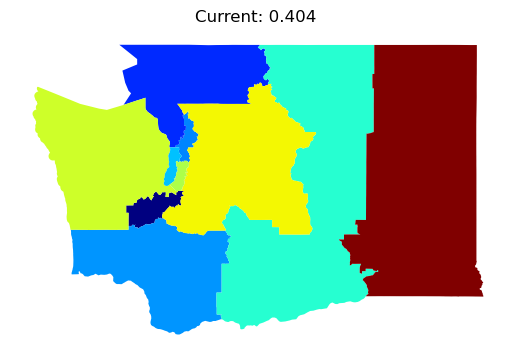

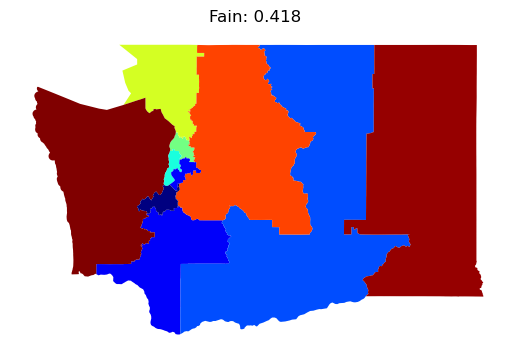

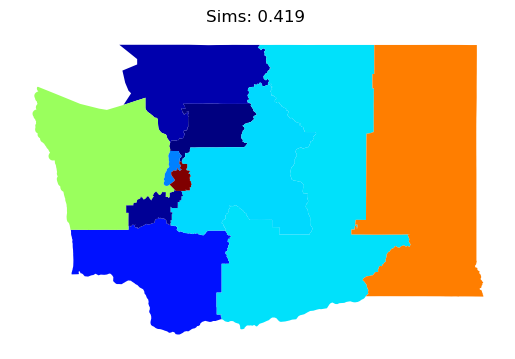

In [46]:
for i in range(5):
    plan = plans[i]
    plan.plot(column='R',cmap='jet')
    plt.axis('off')
    plt.title(f'{plan_names[i]}: {round(np.mean(plan["R"]),3)} ')
    plt.show()

You can ignore the next cell for now - it is just providing some extra setup for the cut edges measure

In [49]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from functools import partial
import pandas
from gerrychain.tree import recursive_tree_part

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper

import geopandas as gpd

import os

from gerrychain.constraints.contiguity import contiguous_components, contiguous

from gerrychain.updaters import cut_edges

from gerrychain.tree import bipartition_tree, find_balanced_edge_cuts_memoization

from gerrychain.updaters import num_spanning_trees

def count_spanning(graph):
    laplacian = nx.laplacian_matrix(graph)
    L = np.delete(np.delete(laplacian.todense(), 0, 0), 1, 1)
    return np.linalg.slogdet(L)[1]

def county_splits(partition, df=Precincts):
    df["current"] = df.index.map(partition.assignment)

    counties = sum(df.groupby("COUNTYFP20")['current'].nunique()>1)
    return counties

def num_comp(part):
  return sum( [.45 < x < .55 for x in part['PRS'].percents('Democratic')])

def nearest_comp_dist(part):

  percs = sorted(list(part['PRS'].percents('Democratic')))

  dists = []

  for x in percs:
    if x < .45:
      dists.append(.45-x)
    elif x < .55:
      dists.append(100)
    else:
      dists.append(x-.55)

  return min(dists)

def improve_comp(part):

  if num_comp(part) > num_comp(part.parent):
    return True

  elif nearest_comp_dist(part) < nearest_comp_dist(part.parent):
    return True

  else:
    if random.random() < .05:
      return True

    else:
      return False



election_names = [
    "PRS",
    "LTG",
    "SOS",
    "TRE",
    "AUD",
    "ATG"
]

num_elections = len(election_names)

election_columns = [
    ["G20PRSBIDE",
"G20PRSTRUM"],
["G20LTGHECK",
"G20LTGLIIA"],
["G20SOSWYMA",
"G20SOSTARL"],
["G20TREPELL",
"G20TREDAVI"],
["G20AUDMCCA",
"G20AUDLEYB"],
["G20ATGFERG",
"G20ATGLARK"],
]

my_updaters = {
    "population": updaters.Tally("POP100", alias="population"),
    "cut_edges": cut_edges,
    "PP":polsby_popper,
    "nWPOP": Election("nWPOP",{"nWPOP":"nWPOP",'WPOP':"P0010003"}),
    "nWVAP": Election("nWVAP",{"nWVAP":"nWVAP",'WVAP':"P0030003"}),
    "nBPOP": Election("nBPOP",{"nBPOP":"nBPOP",'BPOP':"P0010004"}),
    "nBVAP": Election("nBVAP",{"nBVAP":"nBVAP",'BVAP':"P0030004"}),
    "county_splits": county_splits
}


elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)




In [50]:
FPart = GeographicPartition(graph,"Fain",my_updaters)
WPart = GeographicPartition(graph,"Walkinshaw",my_updaters)
GPart = GeographicPartition(graph,"Graves",my_updaters)
SPart = GeographicPartition(graph,"Sims",my_updaters)
EPart = GeographicPartition(graph,"CD",my_updaters)

ideal_con_population = sum(EPart["population"].values()) / len(EPart)


proposed_plans = [FPart,WPart,GPart,SPart,EPart]
plan_names = ["Fain","Walkinshaw","Graves","Sims","Enacted"]

clist = ['green','hotpink','orange','purple','gray']

In [51]:


for i in range(len(proposed_plans)):
    #print("Dem Seats:", plan_names[i],proposed_plans[i]['PRS'].wins("Democratic"))
    print(plan_names[i])
    
    print("Cut Edges:", plan_names[i],len(proposed_plans[i]['cut_edges']))
    
    temp = 0
    for dist in range(10):
        tgraph = proposed_plans[i].subgraphs[dist]
        
        temp += count_spanning(tgraph)


    print("Spanning trees:",plan_names[i],temp)
    print("Mean Polsby_Popper:", plan_names[i],np.mean(list(polsby_popper(proposed_plans[i]).values())))
    print("County Splits:", plan_names[i],county_splits(proposed_plans[i]))

    
    print("Mean Population Deviation",plan_names[i],np.mean([abs((x-ideal_con_population))/ideal_con_population for x in list(proposed_plans[i]['population'].values())]))

Fain
Cut Edges: Fain 895
Spanning trees: Fain 10383.25349135131
Mean Polsby_Popper: Fain 0.2753684877402026
County Splits: Fain 10
Mean Population Deviation Fain 0.002104141302568978
Walkinshaw
Cut Edges: Walkinshaw 948
Spanning trees: Walkinshaw 10367.676936256372
Mean Polsby_Popper: Walkinshaw 0.3007087385874463
County Splits: Walkinshaw 3
Mean Population Deviation Walkinshaw 0.004335364278084076
Graves
Cut Edges: Graves 887
Spanning trees: Graves 10402.35551985846
Mean Polsby_Popper: Graves 0.31272052520326377
County Splits: Graves 9
Mean Population Deviation Graves 0.00263058543873999
Sims
Cut Edges: Sims 821
Spanning trees: Sims 10438.63118396519
Mean Polsby_Popper: Sims 0.3184041040163385
County Splits: Sims 5
Mean Population Deviation Sims 0.001979058258874654
Enacted
Cut Edges: Enacted 999
Spanning trees: Enacted 10325.045757587928
Mean Polsby_Popper: Enacted 0.27005130812691563
County Splits: Enacted 9
Mean Population Deviation Enacted 0.020219223672699287


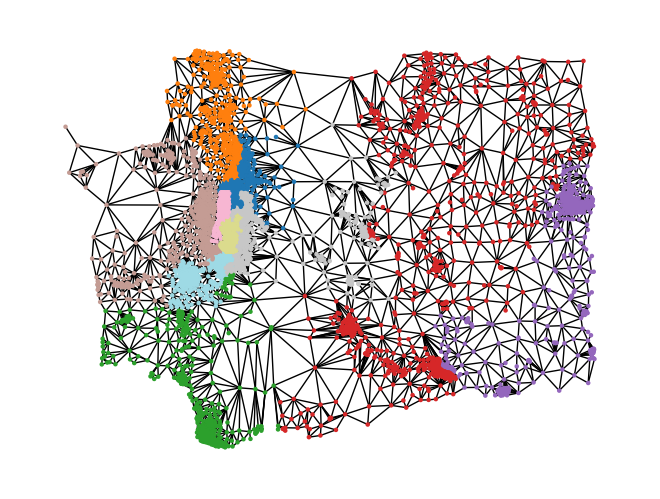

In [52]:
ce = list(WPart['cut_edges'])
nx.draw(graph,pos=[(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()],node_size=5,node_color= [graph.nodes[n]["Walkinshaw"] for n in graph.nodes()],
        cmap='tab20')
plt.show()
nx.draw(graph,pos=[(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()],node_size=5,node_color= [graph.nodes[n]["Walkinshaw"] for n in graph.nodes()],
        edge_color=[e in ce for e in graph.edges()]  ,cmap='tab20')


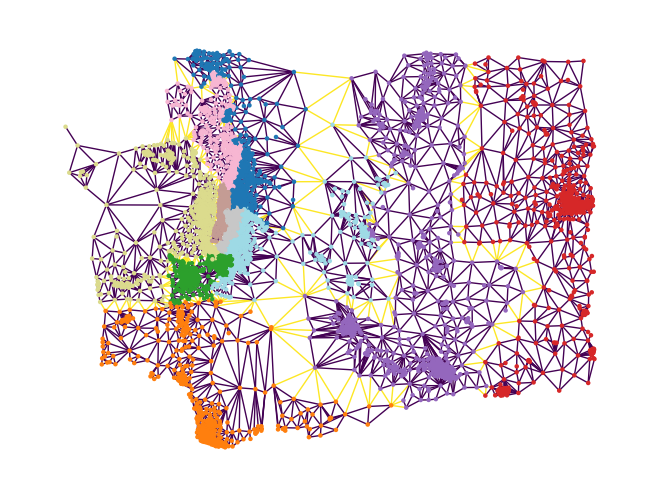

In [53]:
ce = list(EPart['cut_edges'])
nx.draw(graph,pos=[(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()],node_size=5,node_color= [graph.nodes[n]["CD"] for n in graph.nodes()],
        cmap='tab20')
plt.show()
nx.draw(graph,pos=[(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()],node_size=5,node_color= [graph.nodes[n]["CD"] for n in graph.nodes()],
        edge_color=[e in ce for e in graph.edges()]  ,cmap='tab20')


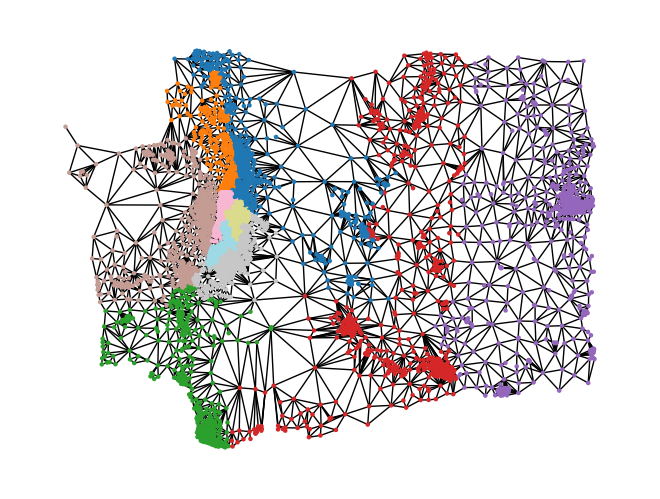

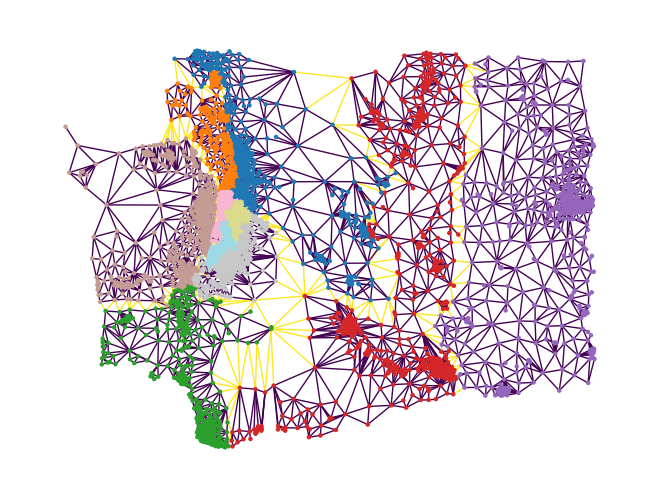

In [54]:
ce = list(GPart['cut_edges'])
nx.draw(graph,pos=[(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()],node_size=5,node_color= [graph.nodes[n]["Graves"] for n in graph.nodes()],
        cmap='tab20')
plt.show()
nx.draw(graph,pos=[(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()],node_size=5,node_color= [graph.nodes[n]["Graves"] for n in graph.nodes()],
        edge_color=[e in ce for e in graph.edges()]  ,cmap='tab20')
